<a href="https://colab.research.google.com/github/Apsod/DD2360HT22/blob/main/hw_4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn==0.12.1
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mon Jan  2 21:40:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------

In [ ]:
import itertools
import subprocess
import seaborn
import numpy as np
import pandas
import seaborn.objects as so
from sklearn.linear_model import *
seaborn.set_style('whitegrid')

In [ ]:


!rm -rf DD2360HT22
!git clone https://github.com/Apsod/DD2360HT22.git


Cloning into 'DD2360HT22'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 334 (delta 146), reused 254 (delta 95), pack-reused 0
Receiving objects: 100% (334/334), 284.72 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [ ]:

!nvcc -arch=sm_61 DD2360HT22/hw_4/ex_3/lab4_ex3_managed.cu -o managed.out
!nvcc -arch=sm_61 DD2360HT22/hw_4/ex_3/lab4_ex3_pinned.cu -o pinned.out
!nvcc -arch=sm_61 DD2360HT22/hw_4/ex_3/lab3_ex2.cu -o old.out

DD2360HT22/hw_4/ex_3/lab4_ex3_managed.cu(127): warning: variable "resultRef" was set but never used

DD2360HT22/hw_4/ex_3/lab4_ex3_pinned.cu(126): warning: variable "resultRef" was set but never used



In [ ]:
! nvprof -o old.nvvp -f ./old.out 2048 2048 2048
! nvprof -o pinned.nvvp -f ./pinned.out 2048 2048 2048
! nvprof -o managed.nvvp -f ./managed.out 2048 2048 2048

==12095== NVPROF is profiling process 12095, command: ./old.out 2048 2048 2048
==12095== Generated result file: /content/old.nvvp
==12126== NVPROF is profiling process 12126, command: ./pinned.out 2048 2048 2048
==12126== Generated result file: /content/pinned.nvvp
==12155== NVPROF is profiling process 12155, command: ./managed.out 2048 2048 2048
==12155== Generated result file: /content/managed.nvvp


In [ ]:
sizes = [2**i for i in range(10, 24)]

#lens = [2**21, 2**20, 2**19, 2**18, 2**17]
#segs = [2**18, 2**17, 2**16, 2**15, 2**14, 2**13]

rows = []

def run(len, seg):
  p = subprocess.run(f'./streaming.out {len} {seg}', shell=True, capture_output=True)
  txt = p.stdout.decode('utf-8')
  lines = txt.strip().split('\n')
  h = float(lines[5].split()[-1])
  k = float(lines[7].split()[-1])
  return h, k

for trial in range(1):
  for len in sizes:
    rows.append((trial, len, len, *run(len, len)))
    for seg in sizes:
      if seg < len:
        rows.append((trial, len, seg, *run(len, seg)))

In [ ]:
df = pandas.DataFrame.from_records(rows, columns=['trial', 'len', 'seglen', 'host', 'kernel'])

In [ ]:

df

,trial,len,seglen,host,kernel
0,0,1024,1024,0.005312,0.066304
1,0,2048,2048,0.008352,0.061152
2,0,2048,1024,0.008224,0.073152
3,0,4096,4096,0.016256,0.052512
4,0,4096,1024,0.017120,0.100576
...,...,...,...,...,...
100,0,8388608,262144,52.335678,12.661120
101,0,8388608,524288,52.492287,12.376064
102,0,8388608,1048576,52.895489,12.517088
103,0,8388608,2097152,52.383678,13.167168


In [ ]:
df['segments'] = (df.len + df.seglen - 1) // df.seglen
df['kernel_flops'] = df.len / (df.kernel * 1e-3)

In [ ]:
normalized = df.merge(df[df.len == df.seglen][['len', 'kernel']], on='len', )
normalized['kernel'] = normalized.kernel_x / normalized.kernel_y

In [ ]:

df.len.to_numpy()

array([   1024,    2048,    2048,    4096,    4096,    4096,    8192,
          8192,    8192,    8192,   16384,   16384,   16384,   16384,
         16384,   32768,   32768,   32768,   32768,   32768,   32768,
         65536,   65536,   65536,   65536,   65536,   65536,   65536,
        131072,  131072,  131072,  131072,  131072,  131072,  131072,
        131072,  262144,  262144,  262144,  262144,  262144,  262144,
        262144,  262144,  262144,  524288,  524288,  524288,  524288,
        524288,  524288,  524288,  524288,  524288,  524288, 1048576,
       1048576, 1048576, 1048576, 1048576, 1048576, 1048576, 1048576,
       1048576, 1048576, 1048576, 2097152, 2097152, 2097152, 2097152,
       2097152, 2097152, 2097152, 2097152, 2097152, 2097152, 2097152,
       2097152, 4194304, 4194304, 4194304, 4194304, 4194304, 4194304,
       4194304, 4194304, 4194304, 4194304, 4194304, 4194304, 4194304,
       8388608, 8388608, 8388608, 8388608, 8388608, 8388608, 8388608,
       8388608, 8388

In [ ]:

del len

In [ ]:

for S, ixs in df.groupby('seglen').groups.items():
  X = (2 * df.iloc[ixs].segments + 1).to_numpy().reshape(-1, 1)
  #print(X)
  Y = df.iloc[ixs].kernel.to_numpy()
  reg = LinearRegression().fit(X, Y)
  score = reg.score(X, Y)
  m = reg.coef_[0]
  k = reg.intercept_
  #so.Plot(X[:, 0], Y).add(so.Dot()).show()
  print(f'S = {S}, score: {score:.2f} len: {len(Y)}\nm = {m:.5f} k = {k:.5f}\n')

S = 1024, score: 1.00 len: 14
m = 0.00504 k = 0.26417

S = 2048, score: 1.00 len: 13
m = 0.00637 k = 0.32291

S = 4096, score: 1.00 len: 12
m = 0.00726 k = 0.16158

S = 8192, score: 1.00 len: 11
m = 0.01127 k = 0.09412

S = 16384, score: 1.00 len: 10
m = 0.01851 k = 0.07342

S = 32768, score: 1.00 len: 9
m = 0.03197 k = 0.05927

S = 65536, score: 1.00 len: 8
m = 0.05733 k = 0.04064

S = 131072, score: 1.00 len: 7
m = 0.10773 k = 0.03124

S = 262144, score: 1.00 len: 6
m = 0.20405 k = 0.06815

S = 524288, score: 1.00 len: 5
m = 0.39295 k = 0.12882

S = 1048576, score: 1.00 len: 4
m = 0.77353 k = 0.16446

S = 2097152, score: 1.00 len: 3
m = 1.54452 k = 0.03499

S = 4194304, score: 1.00 len: 2
m = 3.08818 k = -0.22530

S = 8388608, score: nan len: 1
m = 0.00000 k = 17.49018



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


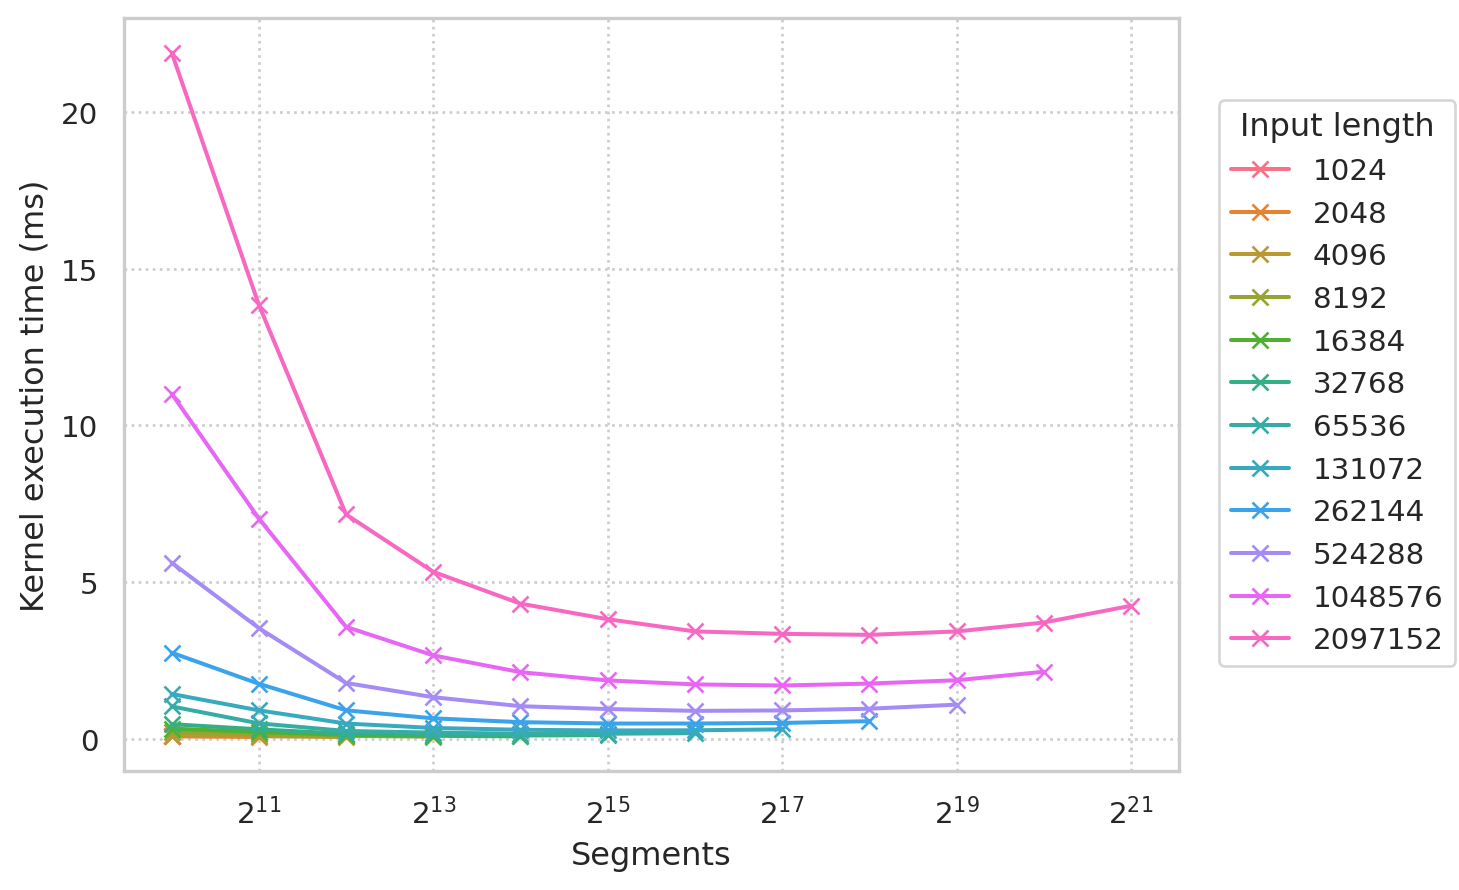

In [ ]:

so.Plot(df, 'seglen', 'kernel', color='len').add(so.Line(marker='x')).label(x='Segments', y='Kernel execution time (ms)', color='Input length').scale(x='log2', color=so.Nominal()).theme({**seaborn.axes_style("whitegrid"), "grid.linestyle": ":"})


In [ ]:

1 / normalized.iloc[normalized.kernel.idxmin()].kernel

1.3112430604066325

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


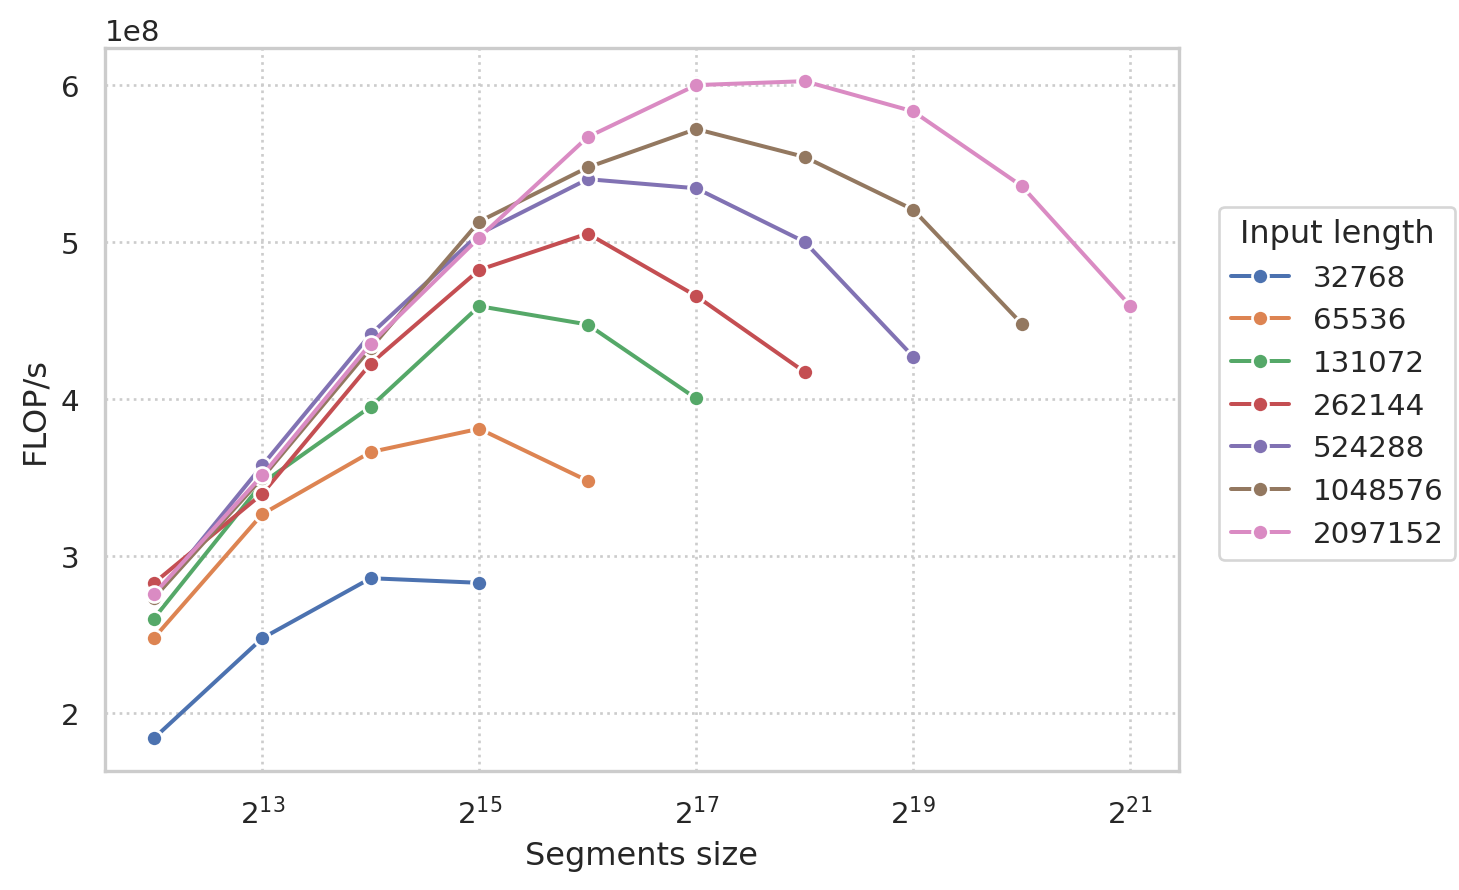

In [ ]:
so.Plot(normalized[(normalized.len>16384) & (normalized.kernel < 2)], 'seglen', 'kernel_flops', color='len').add(so.Line(marker='o', edgecolor='w')).label(x='Segments size', y='FLOP/s', color='Input length').scale(x='log2', color=so.Nominal()).theme({**seaborn.axes_style("whitegrid"), "grid.linestyle": ":"})


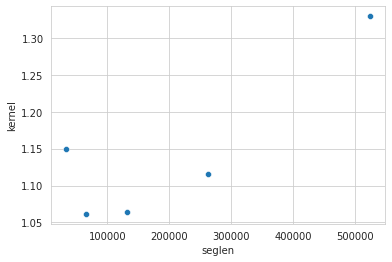

In [ ]:
seaborn.scatterplot(df[df.len == 524288], x='seglen', y='kernel', )

In [ ]:
!bash DD2360HT22/hw_4/ex_2/run.sh

1 1048576 1048576 2.154240
1 1048576 131072 1.700192
1 1048576 32768 1.931104
1 1048576 8192 2.687008
1 524288 524288 1.105728
1 524288 131072 0.918624
1 524288 32768 0.980960
1 524288 8192 1.349632
1 262144 262144 0.572096
1 262144 131072 0.511296
1 262144 32768 0.503808
1 262144 8192 0.696320
2 1048576 1048576 2.173472
2 1048576 131072 1.710112
2 1048576 32768 1.904608
2 1048576 8192 2.783232
2 524288 524288 1.105920
2 524288 131072 0.936704
2 524288 32768 0.976896
2 524288 8192 1.357824
2 262144 262144 0.579584
2 262144 131072 0.509920
2 262144 32768 0.780288
2 262144 8192 0.713024
3 1048576 1048576 2.156576
3 1048576 131072 1.716192
3 1048576 32768 1.921472
3 1048576 8192 2.648256
3 524288 524288 1.116672
3 524288 131072 0.919776
3 524288 32768 0.966656
3 524288 8192 1.365280
3 262144 262144 0.565312
3 262144 131072 0.516096
3 262144 32768 0.506720
3 262144 8192 0.702592
4 1048576 1048576 2.166848
4 1048576 131072 1.704928
4 1048576 32768 1.929216
4 1048576 8192 2.742272
4 524288 5

Thu Dec 22 13:50:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

!nvcc -arch=sm_61 -I/usr/local/cuda/include DD2360HT22/hw_4/ex_4/lab4-ex4-template.cu -o e4 -lcublas -lcusparse
!nvcc -arch=sm_61 -I/usr/local/cuda/include DD2360HT22/hw_4/ex_4/lab4-ex4-template.cu -o e4_noc -lcublas -lcusparse -DNOCONC

In [ ]:
!./e4 128 1000

The X dimension of the grid is 128 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 197213 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 10 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 48 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 1 microseconds 
time spent in SpMV: 32817.000000
number of steps: 1000
The error of the approximation is 1990.137046
The norm is 1337.351611
The relative error of the approximation is 1.488118


In [ ]:

! nvprof -o old.nvvp -f ./old.out 2048 2048 2048


In [ ]:

2**20

1048576

In [ ]:

!sudo ls

DD2360HT22  e4_noc	 e4.nvvp      old.out	  sample_data
e4	    e4_noc.nvvp  managed.out  pinned.out


In [ ]:

!./e4 128 100

The X dimension of the grid is 128 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 112131 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 10 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 48 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 3 microseconds 
time spent in SpMV: 3306.000000
number of steps: 100
The error of the approximation is 2595.336776
The norm is 782.194230
The relative error of the approximation is 3.318021


In [ ]:

!nvprof -o e4.nvvp -f ./e4 33554432 100
!nvprof -o e4_noc.nvvp -f ./e4_noc 33554432 100

The X dimension of the grid is 128 
The number of time steps to perform is 100 
==24786== NVPROF is profiling process 24786, command: ./e4 128 100
Timing - Allocating device memory. 		Elasped 445283 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 15 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 68 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 6 microseconds 
time spent in SpMV: 4041.000000
number of steps: 100
The error of the approximation is 2595.336776
The norm is 782.194230
The relative error of the approximation is 3.318021
==24786== Generated result file: /content/e4.nvvp
The X dimension of the grid is 128 
The number of time steps to perform is 100 
==24809== NVPROF is profiling process 24809, command: ./e4_noc 128 100
Timing - Allocating device memory. 		Elasped 229297 microseconds 
Timing - Initializing the sparse matrix on the host. 

In [ ]:
import math

In [ ]:

#lb = 2 / 100
b = 2 / 100

for i in range(0, 101):
  steps = int(10 ** (i * 2 / 100 + 2))


100 104 109 114 120 125 131 138 144 151 158 165 173 181 190 199 208 218 229 239 251 263 275 288 301 316 331 346 363 380 398 416 436 457 478 501 524 549 575 602 630 660 691 724 758 794 831 870 912 954 1000 1047 1096 1148 1202 1258 1318 1380 1445 1513 1584 1659 1737 1819 1905 1995 2089 2187 2290 2398 2511 2630 2754 2884 3019 3162 3311 3467 3630 3801 3981 4168 4365 4570 4786 5011 5248 5495 5754 6025 6309 6606 6918 7244 7585 7943 8317 8709 9120 9549 10000 

In [ ]:
rows = []
b = 2 / 100
for i in range(0, 101):
  steps = int(10 ** (i * 2 / 100 + 2))
  res = subprocess.run(f'./e4 128 {steps}', shell=True, capture_output=True)
  out = res.stdout.decode('utf-8').strip()
  lines = [l.strip() for l in out.split('\n')]
  error = float(lines[-1].split()[-1])
  steps = int(lines[-4].split()[-1])
  rows.append((steps, error))

df = pandas.DataFrame.from_records(rows, columns=['steps', 'error'])

In [ ]:
df

,steps,error
0,100,3.318021
1,104,3.283109
2,109,3.241508
3,114,3.201976
4,120,3.157008
...,...,...
96,8317,0.129516
97,8709,0.116473
98,9120,0.104318
99,9549,0.093077


/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


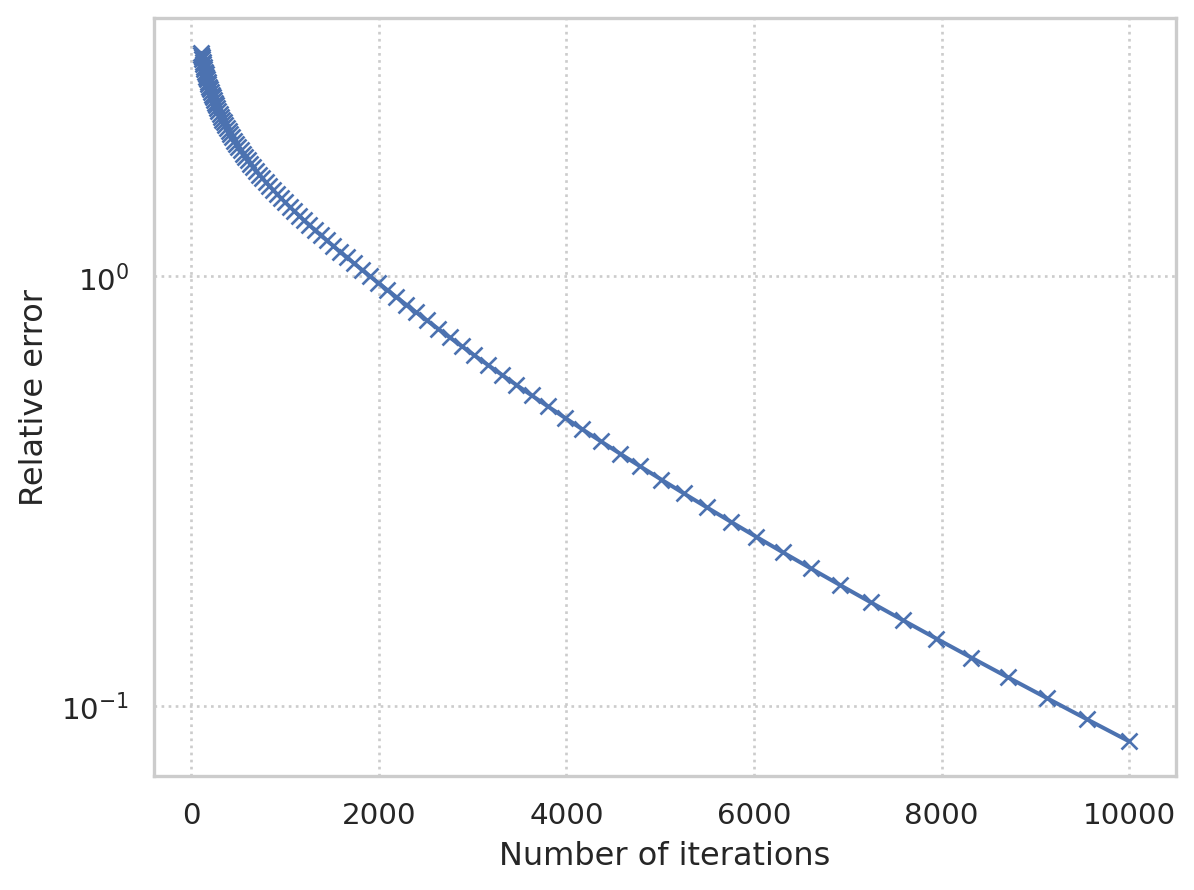

In [ ]:
so.Plot(df, 'steps', 'error').add(so.Line(marker='x')).label(x='Number of iterations', y='Relative error').scale(y='log').theme({**seaborn.axes_style("whitegrid"), "grid.linestyle": ":"})


In [ ]:

for i in range(1, 100+1):
  steps = i * 100
  res = subprocess.run(f'./e4 12800000 {steps}', shell=True, capture_output=True)
  out = res.stdout.decode('utf-8').strip()
  print(out)
  break

The X dimension of the grid is 12800000 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 187532 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 12 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 298538 microseconds 
Timing - Initializing memory on the host. 		Elasped 38362 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 14 microseconds 
number of steps: 100
GFlops/s: 6.543498
The error of the approximation is 900369.529394
The norm is 782.194230
The relative error of the approximation is 1151.081783


In [ ]:

rows = []

In [ ]:

rows = []

for dim in [2**e for e in range(8, 26)]:
  res = subprocess.run(f'./e4 {dim} 100', shell=True, capture_output=True)
  out = res.stdout.decode('utf-8').strip()
  lines = [l.strip() for l in out.split('\n')]
  time = float(lines[-5].split()[-1])
  steps = int(lines[-4].split()[-1])
  dimX = int(lines[0].split()[-1])
  
  flopss = steps * (3 * dimX - 6) / (time * 1e-6)  

  rows.append((dimX, steps, time, flopss))

df = pandas.DataFrame.from_records(rows, columns=['dimX', 'steps', 'time', 'flopss'])

In [ ]:
df

,dimX,steps,time,flopss
0,256,100,3604.0,2.114317e+07
1,512,100,3595.0,4.255911e+07
2,1024,100,3923.0,7.815447e+07
3,2048,100,3878.0,1.582775e+08
4,4096,100,4165.0,2.948860e+08
5,8192,100,4257.0,5.771670e+08
6,16384,100,4574.0,1.074464e+09
7,32768,100,6174.0,1.592128e+09
8,65536,100,8436.0,2.330512e+09
9,131072,100,11976.0,3.283317e+09


/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


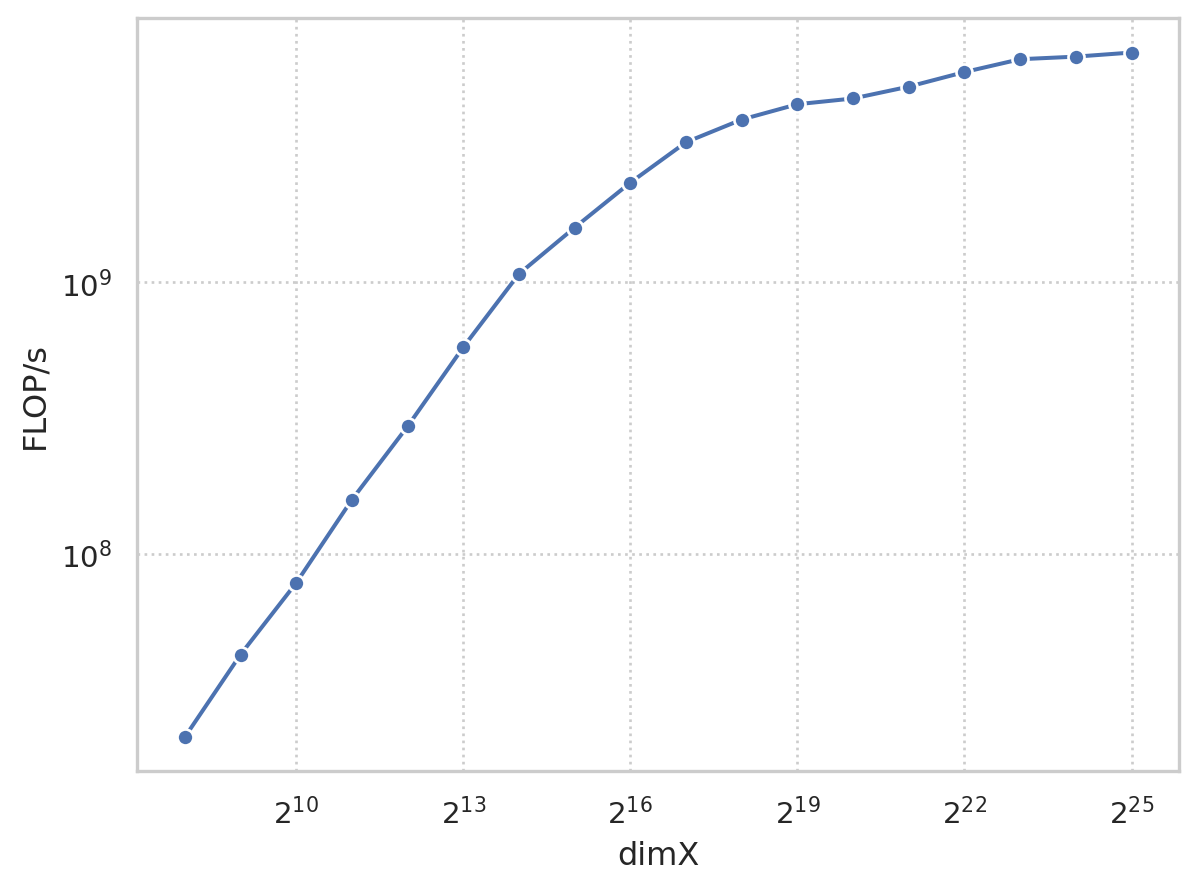

In [ ]:
so.Plot(df, 'dimX', 'flopss').add(so.Line(marker='o', edgecolor='w')).label(x='dimX', y='FLOP/s').scale(x='log2', y='log10').theme({**seaborn.axes_style("whitegrid"), "grid.linestyle": ":"})


In [ ]:
df

,dimX,flops
0,128,0.011410
1,512,0.041803
2,2048,0.151257
3,8192,0.549296
4,32768,1.637209
5,131072,3.356753
6,524288,4.526992
7,2097152,5.049845
